In [54]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [55]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [56]:
import random
import os
image_file = random.sample(os.listdir("_data/combined/test"), 1)[0]
image = cv2.imread(os.path.join("_data/combined/test", image_file))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

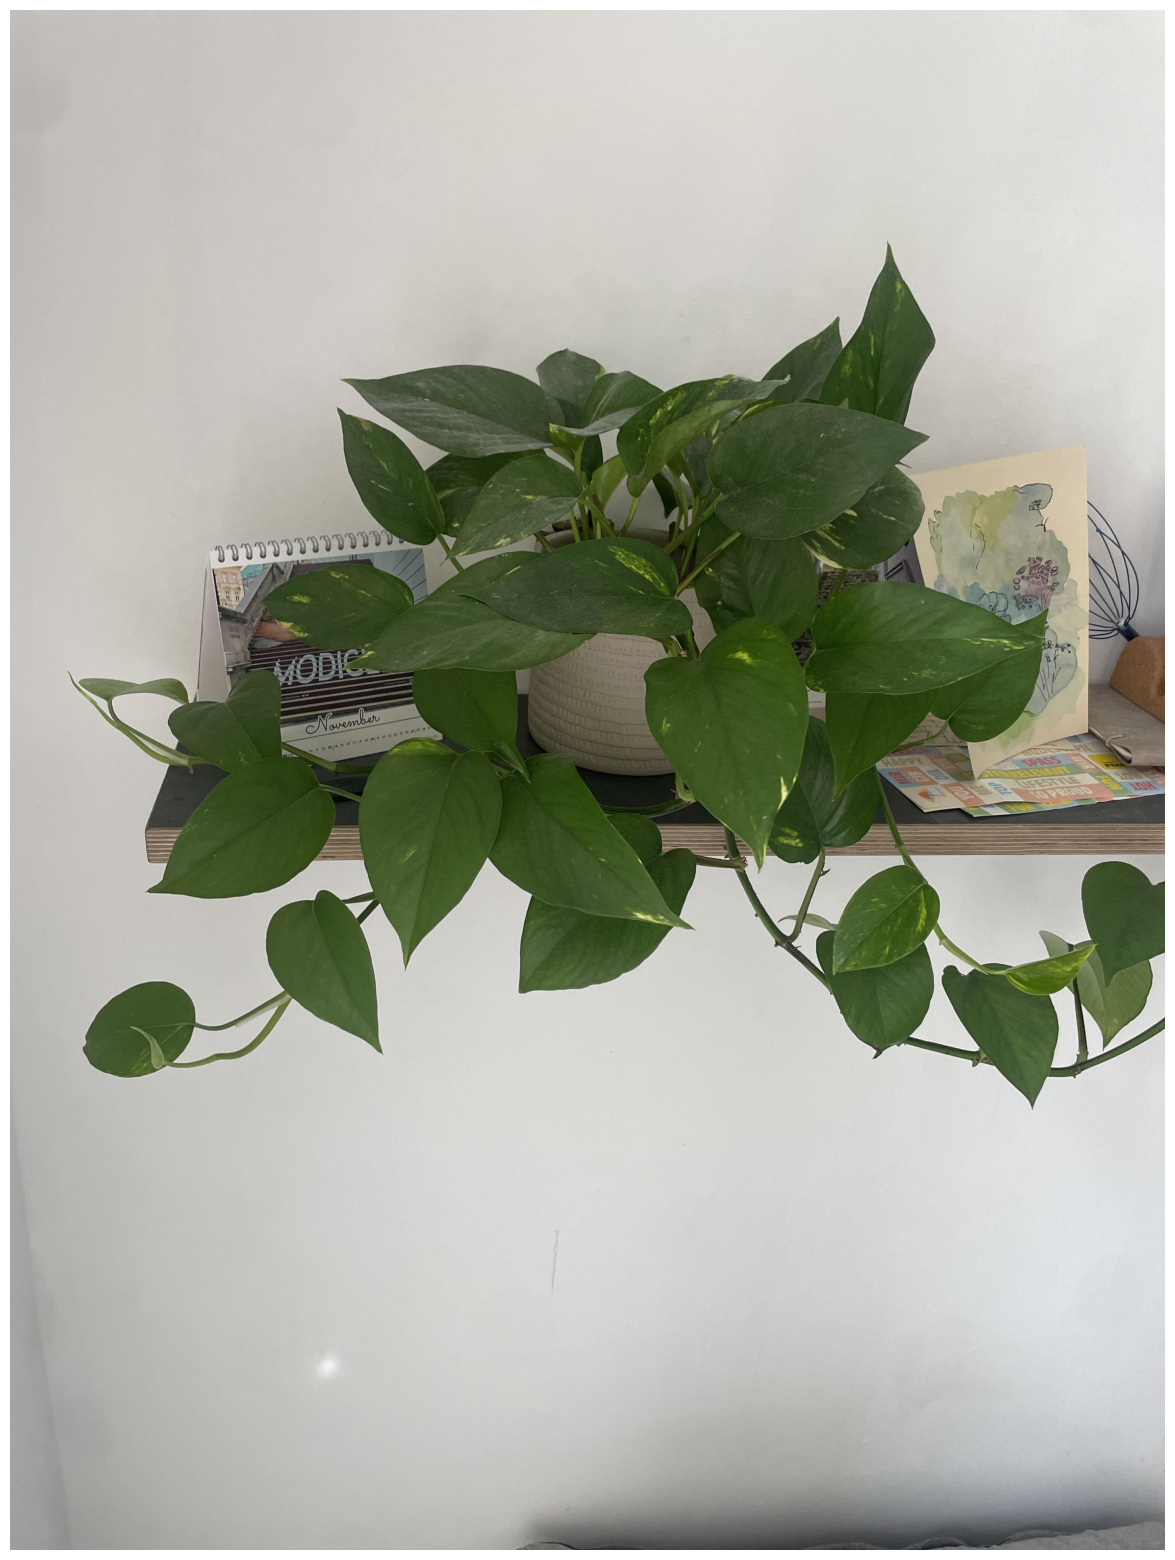

In [57]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [58]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [59]:
masks = mask_generator.generate(image)

In [60]:
print(len(masks))
print(masks[0].keys())
print(masks[0]["bbox"])

82
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[0, 0, 3021, 4031]


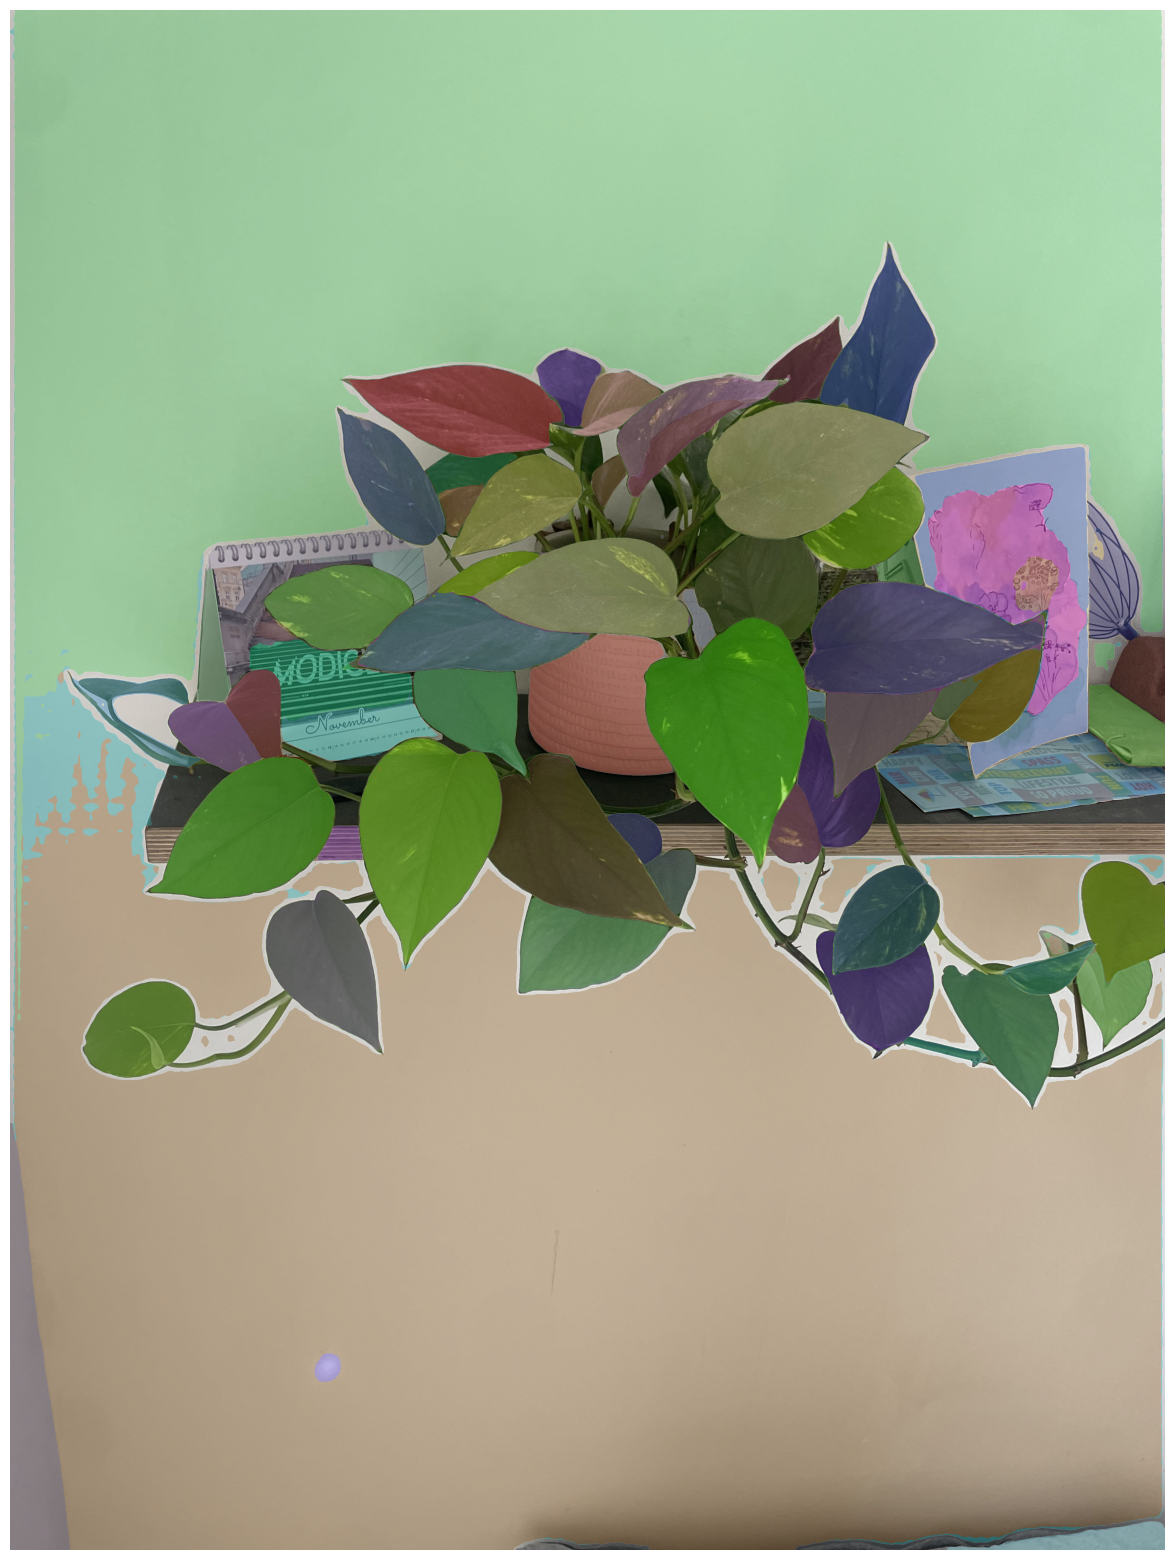

In [61]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [62]:
def get_patches(masks, image):
    return [image[bbox[0]:bbox[0]+bbox[2], bbox[1]:bbox[1]+bbox[3]] for bbox in [mask["bbox"] for mask in masks]]

# YOLO detection 

In [22]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/plant-leaf-detection-and-classification')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# perform inference
results = model.predict(os.path.realpath(os.path.join("_data", "combined", "test", image_file)))

# observe results
print(results[0].boxes)


image 1/1 /home/stefan.steinheber/bachelor/processing/leaf_segmentation/_data/combined/test/test3.jpg: 640x480 5 Blueberrys, 2 gauavas, 1 apple, 38.5ms
Speed: 2.4ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([22., 14., 14., 14., 22., 14., 28., 14.], device='cuda:0')
conf: tensor([0.6934, 0.5878, 0.5857, 0.5853, 0.5585, 0.4639, 0.2858, 0.2625], device='cuda:0')
data: tensor([[1.4180e+03, 2.1964e+03, 2.0904e+03, 3.2700e+03, 6.9341e-01, 2.2000e+01],
        [1.7065e+02, 1.2007e+03, 1.1361e+03, 1.7391e+03, 5.8779e-01, 1.4000e+01],
        [2.0058e+03, 3.3516e+01, 3.0240e+03, 4.8999e+02, 5.8566e-01, 1.4000e+01],
        [9.0139e+02, 7.6179e+02, 1.4239e+03, 1.1691e+03, 5.8530e-01, 1.4000e+01],
        [8.6794e+02, 2.4297e+03, 1.3416e+03, 2.9094e+03, 5.5847e-01, 2.2000e+01],
        [1.7341e+03, 4.2468e+02, 2.4014e+03, 1.1854e+03, 4.6386e-01, 1.4000e+01],
        [1.8935e+03, 1.1829

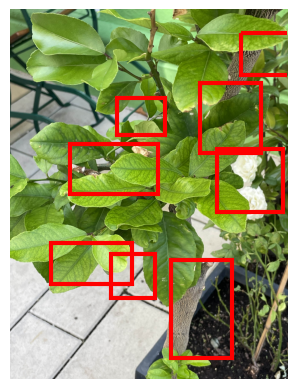

In [32]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(image)
results = results[0].cpu()
for i in range(len(results)):
    rect = patches.Rectangle((results.boxes.xywh[i, 0], results.boxes.xywh[i, 1]),
                             results.boxes.xywh[i, 2], 
                             results.boxes.xywh[i, 3],
                             edgecolor='r', facecolor='none', linewidth=3)
    ax.add_patch(rect)
plt.axis('off')
plt.show() 

# SAM + YOLO detection

In [9]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/plant-leaf-detection-and-classification')

# set model parameters
model.overrides['conf'] = 0.5  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image


results = []

for i in range(len(masks)):
    # cut out the bbox of the mask
    bbox = masks[i]["bbox"]
    mask_patch = image[bbox[0]:bbox[0]+bbox[2], bbox[1]:bbox[1]+bbox[3]]
    
    if 0 in mask_patch.shape:
        continue
    
    # perform inference
    result = model.predict(mask_patch)
    results.append(result[0])

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/ultralytics/nn/tasks.py:634: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, m


0: 640x576 1 tea, 1 coffee, 1 cardamom, 36.0ms
Speed: 4.9ms preprocess, 36.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 576)

0: 640x288 1 tea, 39.0ms
Speed: 1.9ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 608x640 2 cardamoms, 36.4ms
Speed: 2.7ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x480 1 onion, 36.6ms
Speed: 2.2ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 1 cardamom, 50.4ms
Speed: 2.9ms preprocess, 50.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 576x640 1 sugarcane, 41.8ms
Speed: 3.3ms preprocess, 41.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x288 1 ginger, 2 cardamoms, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 288)

0: 576x640 2 cardamoms, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 1.4ms postp

In [10]:
print(len([result for result in results if len(result.boxes) > 0]))

37


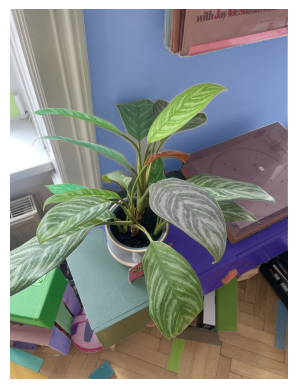

In [11]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.imshow(image)


leaf_masks = [mask for mask, result in zip(masks, results) if len(result.boxes) > 0]

show_anns(leaf_masks)
plt.axis('off')
plt.show() 

# ResNet classification

In [69]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-08-08 11:27:15--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-08-08 11:27:15 (95.1 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [43]:
import torchvision
resnet = torchvision.models.resnet50(pretrained=True)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [78]:
import torchvision.transforms.v2 as transforms

tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),  
])

for mask in masks:
    bbox = mask["bbox"]
    if bbox[2] - bbox[0] == 0 or  bbox[3] - bbox[1] == 0:
        continue
    crop = image[bbox[0]:box[2], bbox[1]:bbox[3], :]
    if crop.shape[0] == 0 or crop.shape[1] == 0:
        continue
    crop = tf(crop)
    crop = crop.unsqueeze(0)
    crop = crop.to(device)
    result = resnet(crop)
    probabilities = torch.nn.functional.softmax(result[0], dim=0)
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 1)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
#    print(result)

bucket 0.005732938647270203
bucket 0.005762018729001284
hook 0.005975078325718641
bucket 0.005998572334647179


# Isolation forest detection

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class SingleClassDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Since it's a single class, we can use a constant label (e.g., 0)
        label = 0
        
        return image, label

# Usage example:
folder_path = '_data/urban_street0_25/images'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleClassDataset(folder_path, transform=transform)

# Create a DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
import torch
from torch.utils.data import DataLoader
from pyod.models.iforest import IForest
import numpy as np

# Initialize and fit the Isolation Forest model
clf = IForest(contamination=0.1)  # Adjust contamination as needed
clf.fit(dataset)

# Get the outlier scores
outlier_scores = clf.decision_function(X)

# Get binary labels (0 for inliers, 1 for outliers)
outlier_labels = clf.predict(X)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3261, 2) + inhomogeneous part.

# Autoencoder leaf-detection

## Training

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [64]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [65]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = SingleClassDataset('_data/urban_street0_25/images', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=16)

In [ ]:
model = Autoencoder().to(device)  # Move model to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [3]:
print("starting training")
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)  # Move input data to GPU
        
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    torch.save(model, "out/autoencoder_latest.pth")

# Save the model
torch.save(model.state_dict(), 'autoencoder_model.pth')

Using device: cuda


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


starting training
Epoch [1/50], Loss: 0.0106
Epoch [2/50], Loss: 0.0062
Epoch [3/50], Loss: 0.0056
Epoch [4/50], Loss: 0.0047
Epoch [5/50], Loss: 0.0034
Epoch [6/50], Loss: 0.0026
Epoch [7/50], Loss: 0.0034
Epoch [8/50], Loss: 0.0037
Epoch [9/50], Loss: 0.0023
Epoch [10/50], Loss: 0.0020
Epoch [11/50], Loss: 0.0024
Epoch [12/50], Loss: 0.0019
Epoch [13/50], Loss: 0.0021
Epoch [14/50], Loss: 0.0020
Epoch [15/50], Loss: 0.0020
Epoch [16/50], Loss: 0.0020
Epoch [17/50], Loss: 0.0017
Epoch [18/50], Loss: 0.0017


KeyboardInterrupt: 

In [35]:
# Function to compute anomaly score
def anomaly_score(img):
    model.eval()
    with torch.no_grad():
        img = img.to(device)  # Move input to GPU
        recon = model(img.unsqueeze(0))
        return nn.MSELoss()(recon, img.unsqueeze(0)).item()

In [ ]:
# Example usage
from PIL import Image

test_img = Image.open('test_image.jpg')
test_tensor = transform(test_img).to(device)  # Move test tensor to GPU
score = anomaly_score(test_tensor)
print(f'Anomaly score: {score}')

## Inference 

In [66]:
#model = torch.load("out/autoencoder_model.pth")
model = torch.load("out/autoencoder_latest.pth")

/tmp/ipykernel_666246/1054232356.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("out/autoencoder_latest.pth")


In [67]:
model.eval()
patches = get_patches(masks, image)
results = []
with torch.no_grad():
    for patch in patches:
        
        patch = transform(Image.fromarray(patch)).to(device)
        result = model(patch)
        results.append(anomaly_score(result))

Detected leaf masks: 60


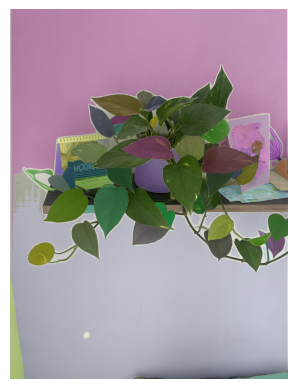

In [68]:
ANOMALY_THRESHOLD = 0.0001
masks_filtered = [mask for mask, result in zip(masks,results) if result < ANOMALY_THRESHOLD]
print("Detected leaf masks:", len(masks_filtered))
fig, ax = plt.subplots()
ax.imshow(image)
show_anns(masks_filtered)
plt.axis('off')
plt.show() 